7/7 [==============================] - 6s 52ms/step
Category Accuracy: 0.9767, F1 Score: 0.9768
Distance Accuracy: 0.9116, F1 Score: 0.9119
Direction Accuracy: 0.9163, F1 Score: 0.9169


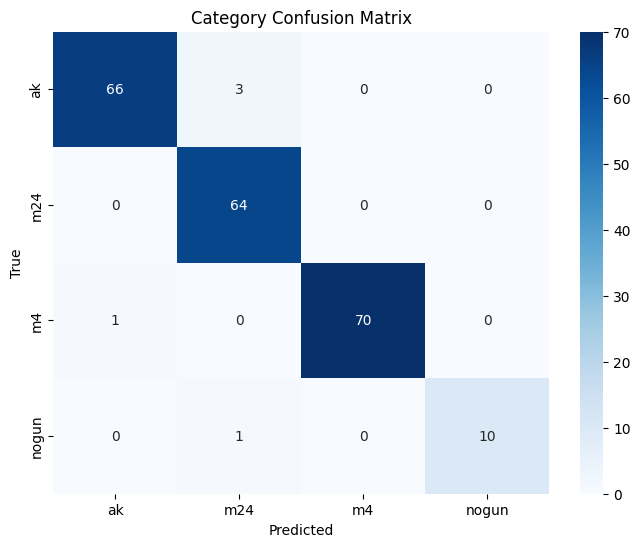

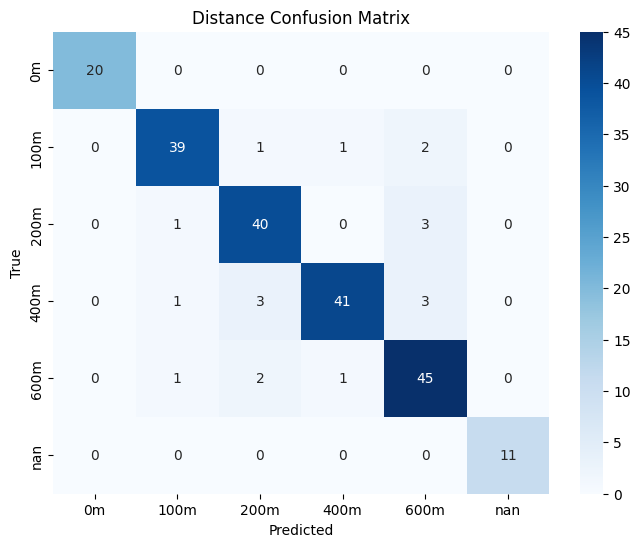

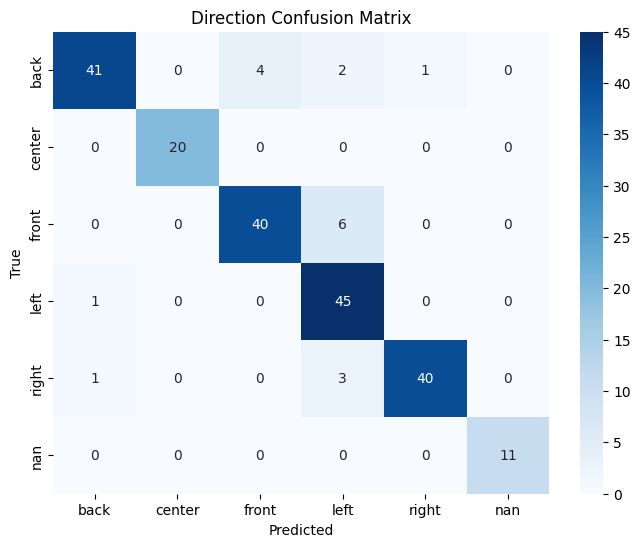

In [1]:
import joblib
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

def preprocess_test_data(csv_path, audio_folder, cate_encoder, dist_encoder, dire_encoder):
    # Load CSV file
    df = pd.read_csv(csv_path)
    
    # Create a list to hold the data
    mel_spectrograms = []
    true_labels = []
    
    # Process each row in the dataframe
    for _, row in df.iterrows():
        audio_file = os.path.join(audio_folder, row['name'])
        y, sr = librosa.load(audio_file, sr=3000, mono=False)  # Load stereo audio at 3 kHz

        # Ensure waveform has two channels and transpose to shape (num_samples, 2)
        if y.ndim == 1:
            y = np.stack([y, y], axis=-1)  # Duplicate if mono
        else:
            y = y.T  # Transpose to get shape (num_samples, 2)
        
        # Compute Mel spectrograms for each channel
        mel_spectrograms_channel_0 = librosa.feature.melspectrogram(y=y[:, 0], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spectrograms_channel_1 = librosa.feature.melspectrogram(y=y[:, 1], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        
        # Stack the spectrograms to get shape (128, num_frames, 2)
        mel_spectrogram = np.stack([mel_spectrograms_channel_0, mel_spectrograms_channel_1], axis=-1)
        
        # Collect the features and labels
        mel_spectrograms.append(mel_spectrogram)
        true_labels.append((
            cate_encoder.transform([row['cate']])[0],
            dist_encoder.transform([row['dist']])[0],
            dire_encoder.transform([row['dire']])[0]
        ))
    
    # Convert lists to numpy arrays
    mel_spectrograms = np.array(mel_spectrograms)
    true_labels = np.array(true_labels)
    
    return mel_spectrograms, true_labels

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(classes)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_model(model_path, test_csv_path, audio_folder):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    
    # Load label encoders
    cate_encoder = joblib.load('cate_encoder.pk2')
    dist_encoder = joblib.load('dist_encoder.pk2')
    dire_encoder = joblib.load('dire_encoder.pk2')
    
    # Load test data
    X_test, y_test = preprocess_test_data(test_csv_path, audio_folder, cate_encoder, dist_encoder, dire_encoder)
    
    # Predict on test data
    predictions = model.predict(X_test)
    
    # Convert predictions to classes
    y_pred_cate = np.argmax(predictions[0], axis=1)
    y_pred_dist = np.argmax(predictions[1], axis=1)
    y_pred_dire = np.argmax(predictions[2], axis=1)
    
    # Calculate accuracy and F1 score for each task
    accuracy_cate = accuracy_score(y_test[:, 0], y_pred_cate)
    f1_cate = f1_score(y_test[:, 0], y_pred_cate, average='weighted')
    
    accuracy_dist = accuracy_score(y_test[:, 1], y_pred_dist)
    f1_dist = f1_score(y_test[:, 1], y_pred_dist, average='weighted')
    
    accuracy_dire = accuracy_score(y_test[:, 2], y_pred_dire)
    f1_dire = f1_score(y_test[:, 2], y_pred_dire, average='weighted')
    
    # Print the results
    print(f'Category Accuracy: {accuracy_cate:.4f}, F1 Score: {f1_cate:.4f}')
    print(f'Distance Accuracy: {accuracy_dist:.4f}, F1 Score: {f1_dist:.4f}')
    print(f'Direction Accuracy: {accuracy_dire:.4f}, F1 Score: {f1_dire:.4f}')
    
    # Plot confusion matrices
    cate_classes = cate_encoder.classes_
    dist_classes = dist_encoder.classes_
    dire_classes = dire_encoder.classes_
    
    # Plot confusion matrices
    plot_confusion_matrix(y_test[:, 0], y_pred_cate, cate_classes, 'Category Confusion Matrix')
    plot_confusion_matrix(y_test[:, 1], y_pred_dist, dist_classes, 'Distance Confusion Matrix')
    plot_confusion_matrix(y_test[:, 2], y_pred_dire, dire_classes, 'Direction Confusion Matrix')

# Paths
test_csv_path = 'cleaned\\test_split.csv'
audio_folder = 'processed_data'

# Evaluate the model
evaluate_model('cnn_transformer_modelv4.h5', test_csv_path, audio_folder)


In [2]:
import joblib
import numpy as np
import librosa
import tensorflow as tf

def preprocess_audio_file(audio_file_path, cate_encoder, dist_encoder, dire_encoder):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=3000, mono=False)  # Load stereo audio at 3 kHz
    
    # Ensure waveform has two channels and transpose to shape (num_samples, 2)
    if y.ndim == 1:
        y = np.stack([y, y], axis=-1)  # Duplicate if mono
    else:
        y = y.T  # Transpose to get shape (num_samples, 2)
    
    # Compute Mel spectrograms for each channel
    mel_spectrograms_channel_0 = librosa.feature.melspectrogram(y=y[:, 0], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    mel_spectrograms_channel_1 = librosa.feature.melspectrogram(y=y[:, 1], sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    
    # Stack the spectrograms to get shape (128, num_frames, 2)
    mel_spectrogram = np.stack([mel_spectrograms_channel_0, mel_spectrograms_channel_1], axis=-1)
    
    # Add a batch dimension
    mel_spectrogram = np.expand_dims(mel_spectrogram, axis=0)
    
    return mel_spectrogram

def predict_audio(audio_file_path, model_path, cate_encoder_path, dist_encoder_path, dire_encoder_path):
    # Load the trained model
    model = tf.keras.models.load_model(model_path)
    
    # Load label encoders
    cate_encoder = joblib.load(cate_encoder_path)
    dist_encoder = joblib.load(dist_encoder_path)
    dire_encoder = joblib.load(dire_encoder_path)
    
    # Preprocess the audio file
    mel_spectrogram = preprocess_audio_file(audio_file_path, cate_encoder, dist_encoder, dire_encoder)
    
    # Predict
    predictions = model.predict(mel_spectrogram)
    
    # Convert predictions to classes
    pred_cate = cate_encoder.inverse_transform([np.argmax(predictions[0])])[0]
    pred_dist = dist_encoder.inverse_transform([np.argmax(predictions[1])])[0]
    pred_dire = dire_encoder.inverse_transform([np.argmax(predictions[2])])[0]
    
    return pred_cate, pred_dist, pred_dire

# Paths to the model and encoders
model_path = 'cnn_transformer_modelv4.h5'
cate_encoder_path = 'cate_encoder.pk2'
dist_encoder_path = 'dist_encoder.pk2'
dire_encoder_path = 'dire_encoder.pk2'

audio_file_path = 'sample_audio\\ak_400m_right_1105.wav'
predictions = predict_audio(audio_file_path, model_path, cate_encoder_path, dist_encoder_path, dire_encoder_path)
print(f'Predicted Category: {predictions[0]}')
print(f'Predicted Distance: {predictions[1]}')
print(f'Predicted Direction: {predictions[2]}')


1/1 [==============================] - 0s 381ms/step
Predicted Category: ak
Predicted Distance: 400m
Predicted Direction: right


In [ ]:
a